In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from celluloid import Camera
import seaborn as sns

sns.set(context='talk', style='ticks', palette='muted')

In [2]:
def createSignal(freqList, lenSignal, timePeriod, burstFreq, burstTime):
    
    t = np.linspace(timePeriod[0], timePeriod[1], lenSignal)
    
    signal =  np.sin(np.pi * 2. * burstFreq * t)     # sin(2 pi f t)
    
    signal[np.logical_or(t < burstTime[0], t > burstTime[1])] = 0
    
    on_time = np.logical_and(t >= burstTime[0], t <= burstTime[1])
    
    signal[on_time] *= np.hanning(on_time.sum()) 
    
    for f in freqList:
        signal = signal + np.sin(2*np.pi*f*t)
        
    return signal


def getFT(signal):
    ft = np.fft.fft(signal)/len(signal)
    return np.abs(ft[:len(signal)//2])

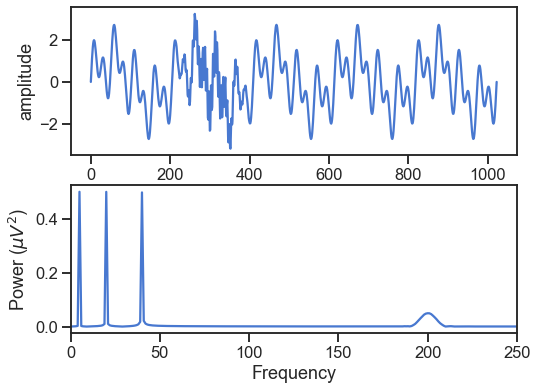

In [3]:
%matplotlib inline
freqList = [ 40, 20, 5]
N = 1024
timePeriod = [0,1]

burstFreq = 200
burstTime = [0.2, 0.4]

x = createSignal(freqList, N, timePeriod, burstFreq,burstTime)
x_ft = getFT(x)

fig, axes = plt.subplots(2, 1, figsize=(8,6))
axes[0].plot(x)
axes[0].set(xlabel='Time', ylabel='amplitude')
axes[1].plot(x_ft)
axes[1].set(xlabel='Frequency', xlim=(0,250), ylabel=r'Power ($\mu V^2$)');


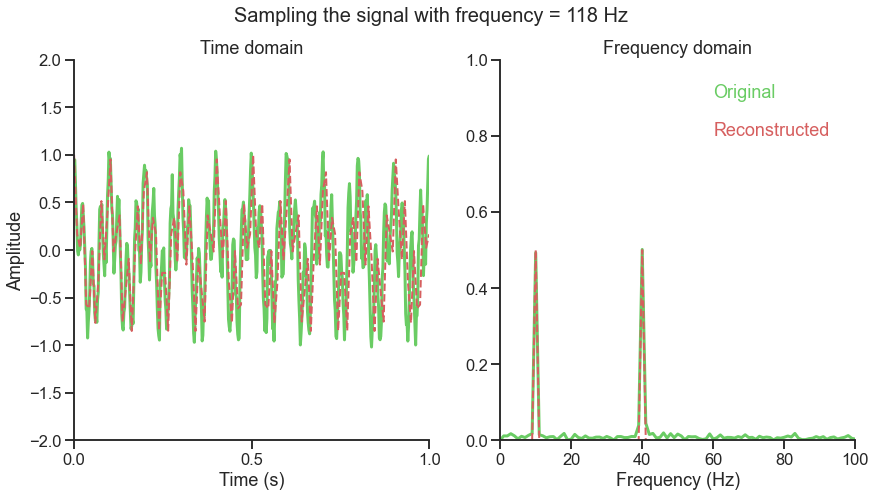

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14,7), sharex=False)

ax[0].set(
    title='Time domain', 
    ylim=(-2, 2), ylabel='Amplitude', yticks=np.arange(-2, 2.1, .5), 
    xlim=(0, 1), xlabel='Time (s)', xticks=np.arange(0, 1.1, 0.5)
)
ax[1].set(
    title='Frequency domain', xlabel='Frequency (Hz)', 
    ylim=(0,1), xlim=(0, 100), ylabel=''
)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

camera = Camera(fig)

# Creating a signal bandlimited to 40 Hz 
f2 = 10
f3 = 40# Hz
tmin = 0
tmax = 1
N = 500
noise = np.random.normal(0,0.1,N)
t = np.linspace(tmin, tmax, N);
x = 0.5*np.cos(2*np.pi*f2*t) + 0.5*np.cos(2*np.pi*f3*t) + noise; # original signal 
ft_x = 2*getFT(x)  

for s_freq in range(10,3*f3, 2):    
    
    # sampling the signal with a different sampling rate
    T = 1/s_freq;
    nmin = np.ceil(tmin / T)
    nmax = np.floor(tmax / T)
    n = np.arange(nmin,nmax,)
    sampled_t = np.linspace(tmin, tmax, s_freq)
    sampled_x = 0.5*np.cos(2*np.pi*f2*n*T) + 0.5*np.cos(2*np.pi*f3*n*T) # sampled signal 
    ft_sampled = 2*getFT(sampled_x)
    
    ax[0].text(
        0.45, 1.1, f'Sampling the signal with frequency = {s_freq} Hz ',
        {'fontsize': 20},
        transform=ax[0].transAxes,
        
    )
    
    ax[0].plot(t, x, 'g', label='Original', lw=3)  
    ax[0].plot(sampled_t, sampled_x, '--r', label='Reconstructed', lw=2)    
    
    ax[1].plot(ft_x, 'g', label='Original', lw=3)
    ax[1].plot(ft_sampled, '--r', label='Reconstructed', lw=2)    
    ax[1].text(    
        60, 0.9, 'Original', {'color': 'g', 'fontsize': 18},
    )
    ax[1].text(    
        60, 0.8, 'Reconstructed', {'color': 'r', 'fontsize': 18},
    )
    
    camera.snap()
    
    
an = camera.animate(interval = 1000, blit=True)
writer = animation.writers['ffmpeg'](fps=1)

an.save('./animations/nyquist_demo.gif',writer=writer, dpi=150 )